In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/dago/anaconda3/bin/python (found version "3.7.6") 
-- Found PythonLibs: /home/dago/anaconda3/lib/libpython3.7m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/dago/Desktop/Facultad/MN/MNTp3/tp3
-- Configuring done
-- Generating do

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/dago/Desktop/Facultad/MN/MNTp3/tp3/notebooks
Python 3.7.6


In [4]:
df = pd.read_csv('../data/train.csv')

In [5]:
df = df[df['ciudad']=='Mérida'].dropna()

In [6]:
x = df['metroscubiertos'].values

In [7]:
y = df['precio'].values

In [8]:
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

In [9]:
x.shape

(518, 1)

In [10]:
from sklearn.linear_model import LinearRegression

"""
Reemplazar por nuestra implementación 
"""

linear_regressor = LinearRegression()
linear_regressor2 = metnum.LinearRegression()

linear_regressor.fit(x,y)
linear_regressor2.fit(x,y)

In [11]:
df['prediction'] = linear_regressor.predict(x)
df['prediction2'] = linear_regressor2.predict(x)

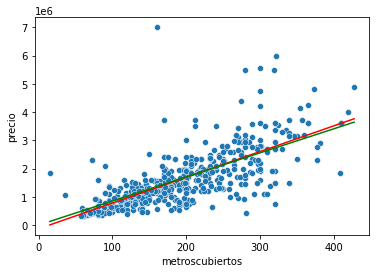

In [12]:
sns.scatterplot(data=df, x='metroscubiertos', y='precio')
sns.lineplot(data=df, x='metroscubiertos', y='prediction', color='red')
sns.lineplot(data=df, x='metroscubiertos', y='prediction2', color='green')


# KFold


In [104]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

def K_Fold(X, y, K=10):
    
    kfold = KFold(n_splits=K)
    #kfold.get_n_splits(X)
    rmse = []
    rmsle = []
    
    for train_index, test_index in kfold.split(X):
        # Separamos el conjunto de entrenamiento y el conjunto de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        linear_regressor = metnum.LinearRegression()
        linear_regressor.fit(X_train, y_train) 
        y_pred = linear_regressor.predict(X_test)
        
        if (y_pred < 0).any():
            print(len(y_pred))
        
        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        rmsle.append(mean_squared_log_error(y_test, y_pred))
        
    return np.mean(rmse), np.mean(rmsle)

In [26]:
df = pd.read_csv('../data/train.csv')
df = df[df['ciudad']=='Mérida'].dropna()
x = df['metroscubiertos'].values
y = df['precio'].values
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)
rmse, rmsle = K_Fold(x, y, 10) # 10% de las muestras para testear
print(rmse, rmsle)

644839.3753734664 0.16553826516219017


# Experimentación


- Revisar las columnas y el precio, ver si encontramos alguna relacion con un primer approach naive.
- Definir la expirementacion :D


- Definir un nuevo feature que sea zona urbana/zona rural por que pueden tener comportamientos distintos


In [27]:
df = pd.read_csv('../data/train.csv')
df.nunique()

id                            240000
titulo                        186191
descripcion                   232187
tipodepropiedad                   24
direccion                     140269
ciudad                           875
provincia                         32
antiguedad                        78
habitaciones                      10
garages                            4
banos                              4
metroscubiertos                  425
metrostotales                    425
idzona                         19719
lat                           112147
lng                           112326
fecha                           1830
gimnasio                           2
usosmultiples                      2
piscina                            2
escuelascercanas                   2
centroscomercialescercanos         2
precio                         15520
dtype: int64

In [32]:
df['banos'].value_counts()

2.0    87683
1.0    58173
3.0    49365
4.0    18558
Name: banos, dtype: int64

# Como primera exprimentacion vamos a probar con todas las features, y sin segmentar para ver si obtenemos resultados. Y dropear los que tengas columnas incompletas

False


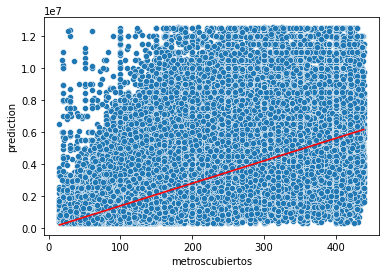

In [125]:
df = pd.read_csv('../data/train.csv')
df2 = df.reindex(columns=["metroscubiertos", "precio"]).dropna()
#df2 = df2[(df2['lat'] > 13) & (df2['lat'] < 34) & (df2['lng'] >= -117) & (df2['lng'] <= -87)]
#df2['lng'] = df2['lng'].abs()

y = df2['precio'].values
df2 = df2.drop(columns=['precio'])
X = df2.to_numpy()

#from sklearn.linear_model import LinearRegression


#linear_regressor = LinearRegression()
linear_regressor = metnum.LinearRegression()
linear_regressor.fit(X,y)

df2['prediction'] = linear_regressor.predict(X)

print((df2['prediction'] < 0).any())

sns.scatterplot(x=df2['metroscubiertos'], y=y)
sns.lineplot(data=df2, x='metroscubiertos', y='prediction', color='red')

#sns.scatterplot(x=df2['antiguedad'], y=y)
#sns.lineplot(data=df2, x='antiguedad', y='prediction', color='red')

# exp para determinar si estan mal clasificados las lng y lat

In [83]:
print(len(df2))
print(len(df2[(df2['lat'] > 13) & (df2['lat'] < 34)]))

print(len(df2))
print(len(df2[(df2['lng'] >= -117) & (df2['lng'] <= -87)]))

58776
58604
58776
57273


In [100]:
print(len(df2[df2['lat'] < 0]))

0


False

In [105]:
df = pd.read_csv('../data/train.csv')
df2 = df.reindex(columns=["antiguedad", "habitaciones", "garages", "banos", "metroscubiertos", "metrostotales", "lat",
                          "lng", "gimnasio", "usosmultiples", "piscina", "escuelascercanas", "centroscomercialescercanos", "precio"]).dropna()
df2 = df2[(df2['lat'] > 13) & (df2['lat'] < 34) & (df2['lng'] >= -117) & (df2['lng'] <= -87)]
df2['lng'] = df2['lng'].abs()

y = df2['precio'].values
df2 = df2.drop(columns=['precio'])
X = df2.to_numpy()

print(K_Fold(X, y, 10))

5727


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

# Observaciones:
- Hacemos modulo de la latitud y longitud para poder usar rmsle (eliminamos aprox 1k de lng mal tageados)
El data set est

# Preguntas:
Como ir viendo los graficos si se experimenta con KFold y esto genera K distintos
